In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import load_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetPath('imdb-5000-movie-dataset')
schema = DatasetSchema.load_schema(DATASET.name)
G = load_igraph(schema, prefix_id=False)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

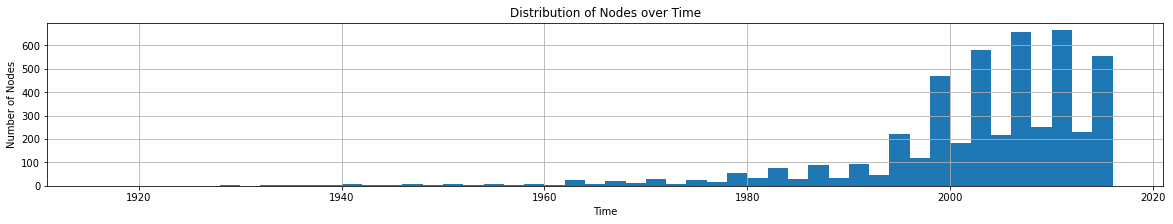

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 16614
Number of Edges: 52251
Density: 0.0003786189362901305


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 6.289996388587938
Median Degree: 3.0


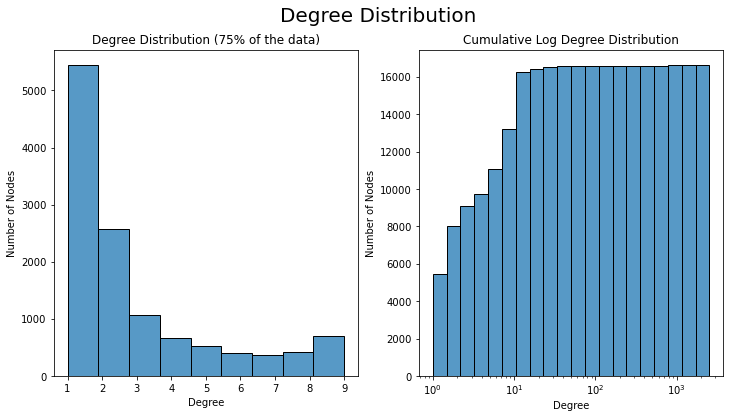

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,2535,Drama
1,1848,Comedy
2,1364,Thriller
3,1113,Action
4,1084,Romance
5,888,Adventure
6,869,Crime
7,595,Sci-Fi
8,583,Fantasy
9,540,Horror


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.0
Diameter: 8


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

Eigenvector Centrality Error: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')


,degree_centrality,betweenness_centrality,page_rank,transitivity
count,16614.000000,16614.000000,16614.000000,11140.0
mean,0.000379,0.000187,0.000060,0.0
std,0.001980,0.007947,0.000259,0.0
min,0.000060,0.000000,0.000016,0.0
25%,0.000060,0.000000,0.000019,0.0
50%,0.000181,0.000000,0.000032,0.0
75%,0.000602,0.000082,0.000089,0.0
max,0.152591,0.668317,0.020398,0.0


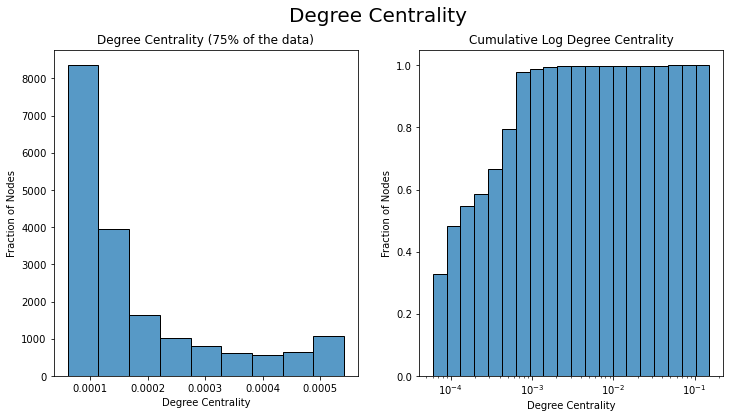

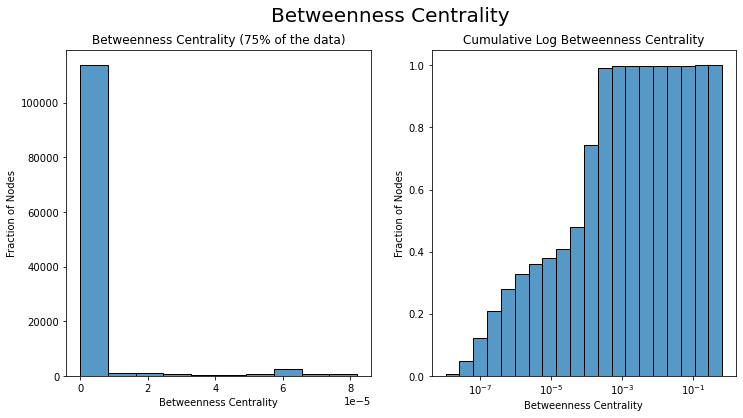

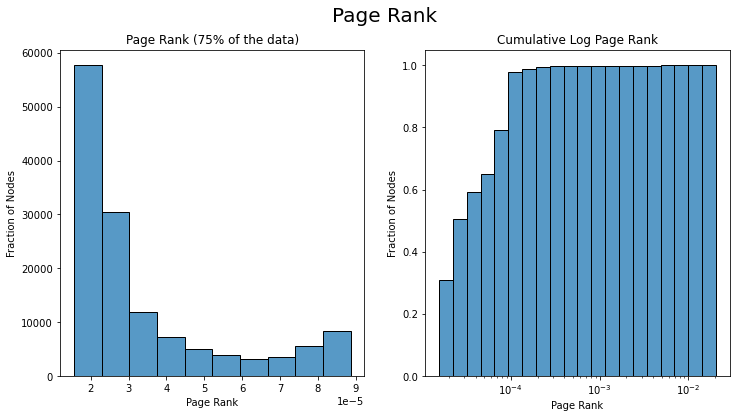

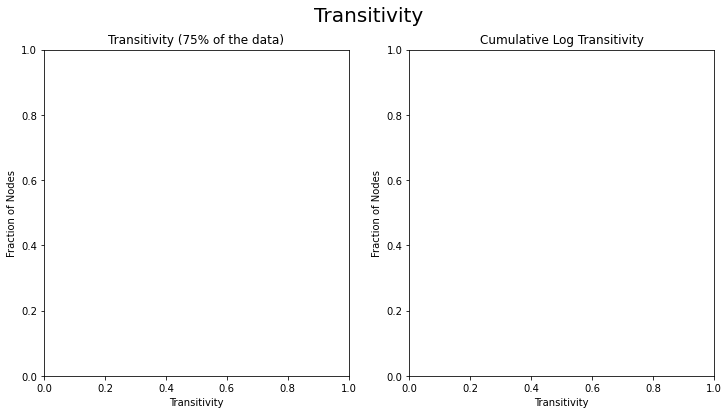

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.152591,Drama,0.668317,Drama,0.020398,Drama,0.0,Nicolas Cage
1,0.111238,Comedy,0.653879,Seven Samurai,0.014613,Comedy,0.0,Brad Bird
2,0.082104,Thriller,0.346121,Madadayo,0.010531,Thriller,0.0,Dean Parisot
3,0.066996,Action,0.170036,Action,0.008508,Romance,0.0,John Stockwell
4,0.065250,Romance,0.141356,Adventure,0.008349,Action,0.0,Mel Brooks
5,0.053452,Adventure,0.068929,Comedy,0.006652,Adventure,0.0,Larry Charles
6,0.052308,Crime,0.030131,Thriller,0.006593,Crime,0.0,Tony Richardson
7,0.035815,Sci-Fi,0.016870,Romance,0.004606,Horror,0.0,Elia Kazan
8,0.035093,Fantasy,0.016581,Horror,0.004553,Sci-Fi,0.0,Pan Nalin
9,0.032505,Horror,0.009110,Documentary,0.004413,Fantasy,0.0,Ayurveda: Art of Being


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 1
Size of the largest component: 16614


Text(0.5, 1.0, 'Connected Components')

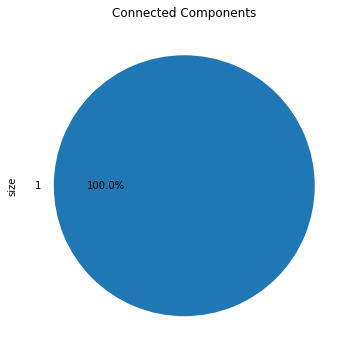

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components())], index=range(1,len(G.components())+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 4


,type,count,degree_avg,degree_median
Person,Person,8491,2.300318,1.0
Genre,Genre,26,543.576923,265.5
Keyword,Keyword,3178,5.848332,3.0
Movie,Movie,4919,10.622281,11.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

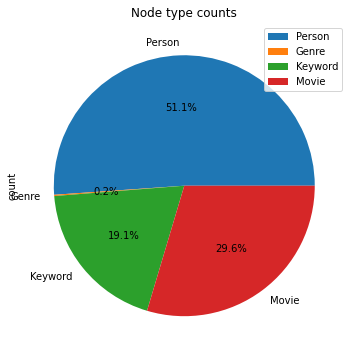

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

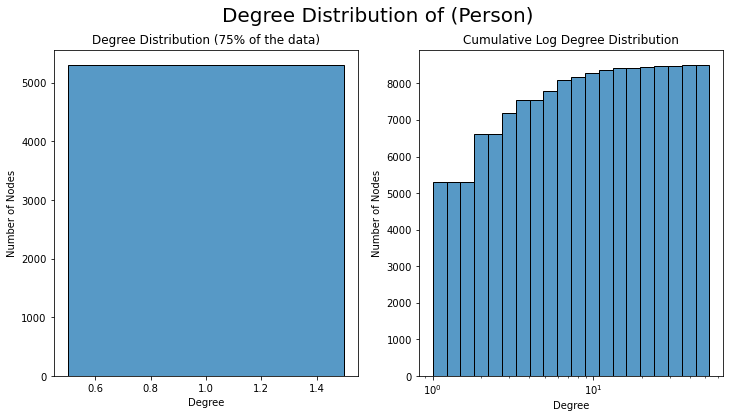

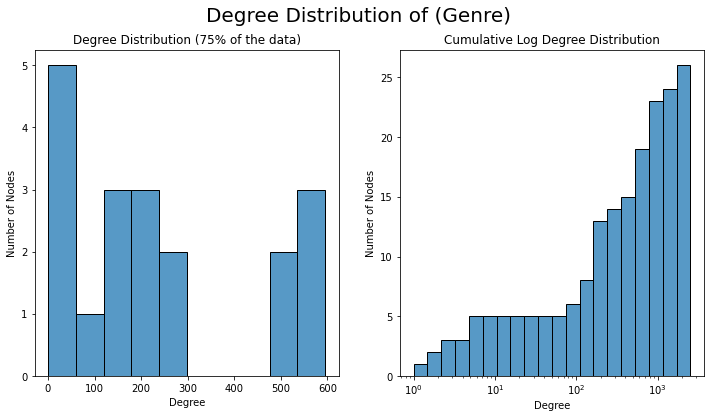

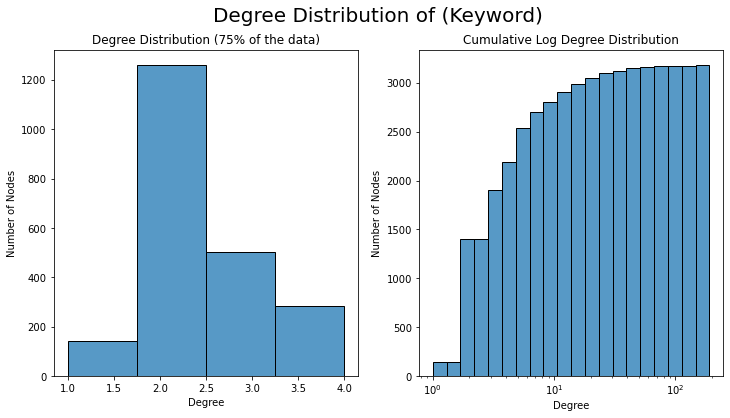

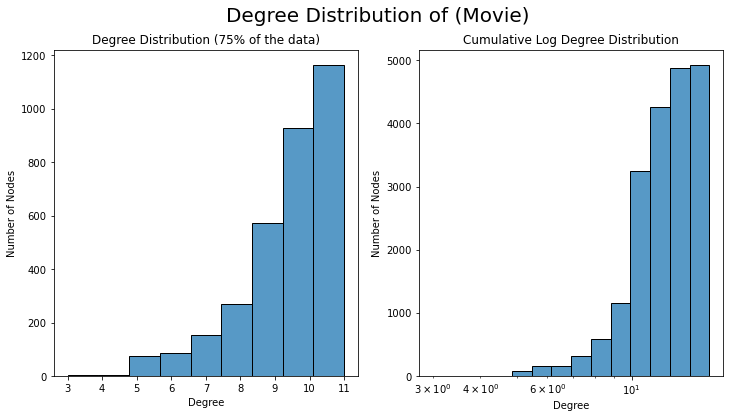

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Person)


,value,label
0,53,Robert De Niro
1,43,Morgan Freeman
2,38,Bruce Willis
3,38,Steve Buscemi
4,37,Matt Damon
5,36,Clint Eastwood
6,36,Johnny Depp
7,33,Nicolas Cage
8,33,Woody Allen
9,33,Brad Pitt


Top 10 Degree Nodes of Type (Genre)


,value,label
0,2535,Drama
1,1848,Comedy
2,1364,Thriller
3,1113,Action
4,1084,Romance
5,888,Adventure
6,869,Crime
7,595,Sci-Fi
8,583,Fantasy
9,540,Horror


Top 10 Degree Nodes of Type (Keyword)


,value,label
0,191,love
1,164,friend
2,157,murder
3,129,death
4,125,police
5,91,new york city
6,88,high school
7,80,alien
8,71,boy
9,70,school


Top 10 Degree Nodes of Type (Movie)


,value,label
0,16,Alpha and Omega 4: The Legend of the Saw Tooth...
1,16,Reindeer Games
2,16,Lilo & Stitch
3,16,Big Hero 6
4,16,Tangled
5,16,The Prince of Egypt
6,16,TMNT
7,15,Teenage Mutant Ninja Turtles III
8,15,Anastasia
9,15,Dylan Dog: Dead of Night


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 4


,type,count
ACTED_IN,ACTED_IN,14715
DIRECTED,DIRECTED,4817
HAS_GENRE,HAS_GENRE,14133
HAS_KEYWORD,HAS_KEYWORD,18586


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

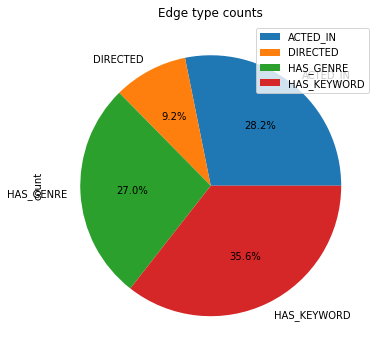

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Person


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.003190,Robert De Niro,0.000104,Morgan Freeman,0.000385,Robert De Niro,0.0,John Schultz
1,0.002588,Morgan Freeman,0.000085,Alfre Woodard,0.000314,Morgan Freeman,0.0,Katie Aselton
2,0.002287,Steve Buscemi,0.000074,Clint Eastwood,0.000274,Matt Damon,0.0,Benedict Wong
3,0.002287,Bruce Willis,0.000036,Michael Moore,0.000271,Bruce Willis,0.0,Sean Young
4,0.002227,Matt Damon,0.000035,Bill Murray,0.000270,Steve Buscemi,0.0,Mary McDonnell
5,0.002167,Johnny Depp,0.000034,Robert De Niro,0.000264,Johnny Depp,0.0,Yimou Zhang
6,0.002167,Clint Eastwood,0.000033,Johnny Depp,0.000247,Will Ferrell,0.0,Sofia Coppola
7,0.001986,Nicolas Cage,0.000025,David Mamet,0.000244,Nicolas Cage,0.0,Jimmy Shergill
8,0.001986,Woody Allen,0.000023,Matt Damon,0.000240,Brad Pitt,0.0,Howard Keel
9,0.001986,Denzel Washington,0.000022,Steve Buscemi,0.000239,Liam Neeson,0.0,Barry Bostwick


Top 10 Nodes by Statistic for Genre


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.152591,Drama,0.668317,Drama,0.020398,Drama,0.0,Drama
1,0.111238,Comedy,0.170036,Action,0.014613,Comedy,0.0,Short
2,0.082104,Thriller,0.141356,Adventure,0.010531,Thriller,0.0,War
3,0.066996,Action,0.068929,Comedy,0.008508,Romance,0.0,Crime
4,0.065250,Romance,0.030131,Thriller,0.008349,Action,0.0,Romance
5,0.053452,Adventure,0.016870,Romance,0.006652,Adventure,0.0,Documentary
6,0.052308,Crime,0.016581,Horror,0.006593,Crime,0.0,History
7,0.035815,Sci-Fi,0.009110,Documentary,0.004606,Horror,0.0,Adventure
8,0.035093,Fantasy,0.007422,Crime,0.004553,Sci-Fi,0.0,Reality-TV
9,0.032505,Horror,0.006801,Fantasy,0.004413,Fantasy,0.0,Comedy


Top 10 Nodes by Statistic for Keyword


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.011497,love,0.004936,birthday,0.001496,love,0.0,orc
1,0.009872,friend,0.004784,japan,0.001267,friend,0.0,drugs
2,0.009450,murder,0.004642,battle,0.001176,murder,0.0,middle school
3,0.007765,death,0.003449,professor,0.000972,death,0.0,teacher student relationship
4,0.007524,police,0.000657,beer,0.000969,police,0.0,nazis
5,0.005478,new york city,0.000591,love,0.000703,new york city,0.0,prisoner of war
6,0.005297,high school,0.000549,death,0.000698,high school,0.0,rescue mission
7,0.004816,alien,0.000541,murder,0.000601,alien,0.0,mormon
8,0.004274,boy,0.000512,samurai,0.000557,school,0.0,ancient egypt
9,0.004214,revenge,0.000454,friend,0.000550,boy,0.0,alter ego


Top 10 Nodes by Statistic for Movie


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000963,Alpha and Omega 4: The Legend of the Saw Tooth...,0.653879,Seven Samurai,0.000215,Dekalog,0.0,Rodeo Girl
1,0.000963,Lilo & Stitch,0.346121,Madadayo,0.000151,Alpha and Omega 4: The Legend of the Saw Tooth...,0.0,They Came Together
2,0.000963,TMNT,0.001014,Touching the Void,0.000148,Man on Wire,0.0,Incendies
3,0.000963,Reindeer Games,0.000998,Antarctica: A Year on Ice,0.000148,The Prince of Egypt,0.0,Spy Hard
4,0.000963,Big Hero 6,0.000987,Super Size Me,0.000146,The Return of the Living Dead,0.0,The Astronaut's Wife
5,0.000963,The Prince of Egypt,0.000910,What the #$*! Do We (K)now!?,0.000146,Airlift,0.0,Our Idiot Brother
6,0.000963,Tangled,0.000810,The Square,0.000145,Home,0.0,Flushed Away
7,0.000903,Waltz with Bashir,0.000794,Fahrenheit 9/11,0.000145,Circle,0.0,Stay Alive
8,0.000903,Jimmy Neutron: Boy Genius,0.000787,Waltz with Bashir,0.000145,Metropolis,0.0,Dark Blue
9,0.000903,Flyboys,0.000783,Hoop Dreams,0.000144,Wicker Park,0.0,Johnny Suede


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 1.1102230246251565e-16


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.44759455320953073
Number of communities: 59


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

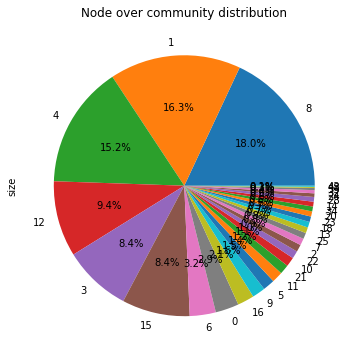

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.007283,Documentary,0.009110,Documentary,0.001456,Documentary,0.0,Dreama Walker
1,0.000903,character name in title,0.001014,Touching the Void,0.000144,character name in title,0.0,Tarnation
2,0.000843,concert,0.000998,Antarctica: A Year on Ice,0.000140,The Red Violin,0.0,Big Fat Liar
3,0.000783,Blood and Chocolate,0.000987,Super Size Me,0.000134,Crop Circles: Quest for Truth,0.0,The Jimmy Show
4,0.000722,Novocaine,0.000810,The Square,0.000134,Wal-Mart: The High Cost of Low Price,0.0,Winged Migration
5,0.000722,Big Fat Liar,0.000794,Fahrenheit 9/11,0.000133,No End in Sight,0.0,Bowling for Columbine
6,0.000722,Straight Outta Compton,0.000777,Jackass: The Movie,0.000130,Sea Rex 3D: Journey to a Prehistoric World,0.0,Jackass: The Movie
7,0.000722,Rapa Nui,0.000720,Sicko,0.000127,Super Size Me,0.0,Martin Lawrence Live: Runteldat
8,0.000722,The Life Before Her Eyes,0.000678,Oceans,0.000125,Indie Game: The Movie,0.0,Crop Circles: Quest for Truth
9,0.000722,1776,0.000669,Bowling for Columbine,0.000125,The Gatekeepers,0.0,Fahrenheit 9/11


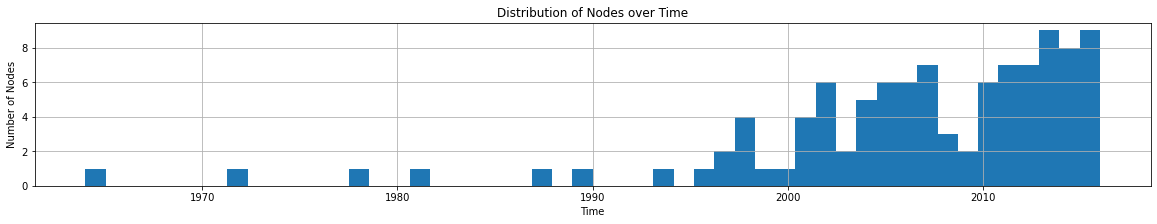

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.082104,Thriller,0.170036,Action,0.010531,Thriller,0.0,Oliver Platt
1,0.066996,Action,0.030131,Thriller,0.008349,Action,0.0,Phone Booth
2,0.052308,Crime,0.007422,Crime,0.006593,Crime,0.0,The Bank Job
3,0.029194,Mystery,0.006192,Mystery,0.003755,Mystery,0.0,Texas Rangers
4,0.009450,murder,0.001319,Western,0.001176,murder,0.0,The Skulls
5,0.007765,death,0.000549,death,0.000972,death,0.0,Vertical Limit
6,0.007524,police,0.000541,murder,0.000969,police,0.0,The Whole Nine Yards
7,0.005658,Western,0.000482,Echo Dr.,0.000751,Western,0.0,Birthday Girl
8,0.004214,revenge,0.000437,Perrier's Bounty,0.000534,revenge,0.0,The Patriot
9,0.004153,fbi,0.000411,Goddess of Love,0.000512,drugs,0.0,Gone in Sixty Seconds


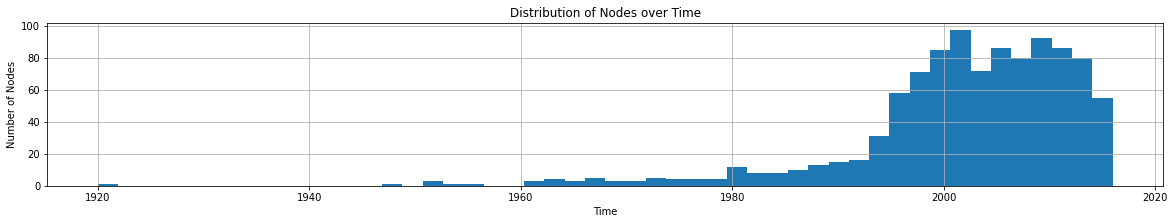

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000783,The Purge: Anarchy,0.000419,The Lords of Salem,0.000134,The Greatest Show on Earth,0.0,Snoop Dogg
1,0.000783,Death Calls,0.000411,The Greatest Show on Earth,0.000130,Death Calls,0.0,voodoo
2,0.000783,The Brothers Bloom,0.000387,Death Calls,0.000129,Rize,0.0,Poetic Justice
3,0.000722,Anacondas: The Hunt for the Blood Orchid,0.000385,Child's Play,0.000125,Smiling Fish & Goat on Fire,0.0,Child's Play 2
4,0.000722,Kung Fu Hustle,0.000369,Anacondas: The Hunt for the Blood Orchid,0.000119,Kung Fu Hustle,0.0,Child's Play
5,0.000722,Seed of Chucky,0.000342,May,0.000119,Child's Play,0.0,The Running Man
6,0.000722,The Running Man,0.000328,The Brothers Bloom,0.000114,Airplane!,0.0,Modern Problems
7,0.000722,The Lords of Salem,0.000300,Kung Fu Hustle,0.000113,House of 1000 Corpses,0.0,Airplane!
8,0.000662,Poetic Justice,0.000281,Poetic Justice,0.000113,The Running Man,0.0,Trapeze
9,0.000662,The Greatest Show on Earth,0.000270,Trapeze,0.000113,Trapeze,0.0,The Greatest Show on Earth


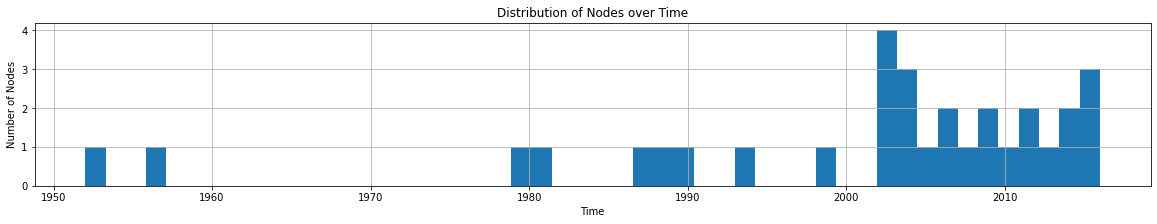

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.017516,Biography,0.653879,Seven Samurai,0.002299,Biography,0.0,Laurence Olivier
1,0.012641,War,0.346121,Madadayo,0.001684,War,0.0,Madadayo
2,0.012159,History,0.004784,japan,0.001618,History,0.0,A Passage to India
3,0.001806,Tom Hanks,0.002006,Biography,0.000208,Tom Hanks,0.0,Red Dawn
4,0.001445,suicide,0.001196,History,0.000202,suicide,0.0,Young Sherlock Holmes
5,0.001264,china,0.001124,War,0.000175,jewish,0.0,Shanghai Surprise
6,0.001204,jewish,0.000787,Waltz with Bashir,0.000173,china,0.0,The Last Emperor
7,0.001144,japan,0.000781,Faith Connections,0.000166,faith,0.0,Iguana
8,0.001144,faith,0.000560,Wasabi,0.000164,japan,0.0,Glory
9,0.001144,orphan,0.000512,samurai,0.000162,india,0.0,Henry V


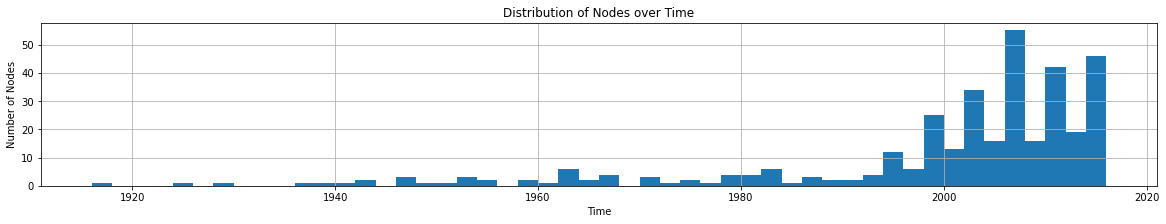

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.053452,Adventure,0.141356,Adventure,0.006652,Adventure,0.0,Ian Whyte
1,0.035815,Sci-Fi,0.006801,Fantasy,0.004553,Sci-Fi,0.0,Fantasia 2000
2,0.035093,Fantasy,0.005834,Family,0.004413,Fantasy,0.0,The Iron Giant
3,0.032144,Family,0.005533,Sci-Fi,0.004128,Family,0.0,Shrek
4,0.014447,Animation,0.004642,battle,0.001841,Animation,0.0,Blast from the Past
5,0.007885,Musical,0.001206,Animation,0.001073,Musical,0.0,Small Soldiers
6,0.004816,alien,0.000910,What the #$*! Do We (K)now!?,0.000601,alien,0.0,Star Wars: Episode III - Revenge of the Sith
7,0.004274,boy,0.000681,Musical,0.000550,boy,0.0,Star Wars: Episode II - Attack of the Clones
8,0.003311,dog,0.000629,Alpha and Omega 4: The Legend of the Saw Tooth...,0.000426,dog,0.0,Corpse Bride
9,0.003250,island,0.000620,Teenage Mutant Ninja Turtles III,0.000421,island,0.0,The Emperor's New Groove


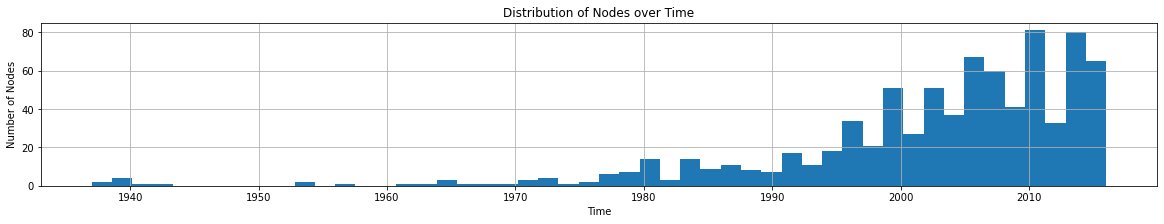

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000783,Jay Hernandez,0.000373,Gunless,0.000142,Standard Operating Procedure,0.0,Jeanne Moreau
1,0.000783,Attack the Block,0.000359,Act of Valor,0.000136,Chasing Liberty,0.0,Twin Falls Idaho
2,0.000783,Act of Valor,0.000321,Valley of the Wolves: Iraq,0.000131,Act of Valor,0.0,Woodstock
3,0.000722,Subconscious,0.000321,The Passion of the Christ,0.000130,Woodstock,0.0,Alien Zone
4,0.000722,Gunless,0.000316,A Separation,0.000127,Murderball,0.0,Silverado
5,0.000722,Gory Gory Hallelujah,0.000316,Shanghai Knights,0.000127,Alien Zone,0.0,Bang
6,0.000722,Ever After: A Cinderella Story,0.000314,Apocalypto,0.000126,Valley of the Wolves: Iraq,0.0,Ever After: A Cinderella Story
7,0.000722,Silverado,0.000304,What Dreams May Come,0.000126,A Separation,0.0,What Dreams May Come
8,0.000722,Standard Operating Procedure,0.000297,The Mothman Prophecies,0.000125,The Passion of the Christ,0.0,The Basket
9,0.000662,Chasing Liberty,0.000295,Quartet,0.000123,Subconscious,0.0,quadriplegic


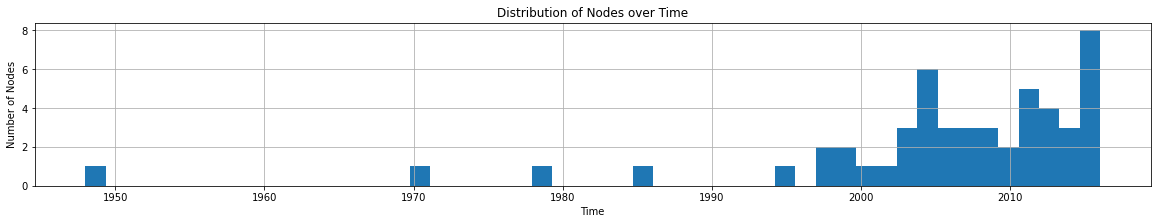

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.01413888380669072
Number of communities: 94


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

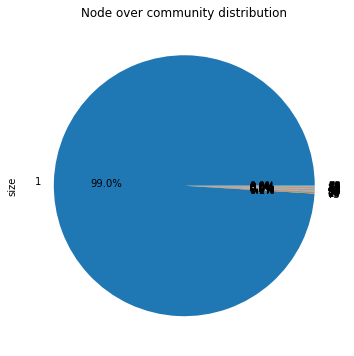

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000241,Star Wars: Episode VII - The Force Awakens ...,0.00012,Star Wars: Episode VII - The Force Awakens ...,0.000066,Star Wars: Episode VII - The Force Awakens ...,0.0,Star Wars: Episode VII - The Force Awakens ...
1,0.000120,Doug Walker,0.00000,Doug Walker,0.000028,Doug Walker,NaN,Doug Walker
2,0.000060,Rob Walker,0.00000,Rob Walker,0.000028,Rob Walker,NaN,Rob Walker


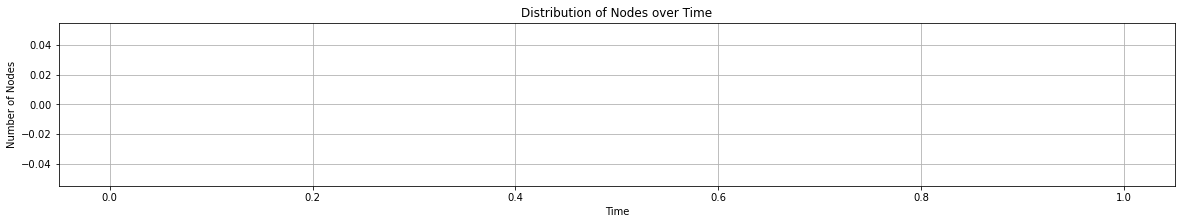

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.152591,Drama,0.668317,Drama,0.020398,Drama,0.0,Oliver Platt
1,0.111238,Comedy,0.653879,Seven Samurai,0.014613,Comedy,0.0,Star Wars: Episode II - Attack of the Clones
2,0.082104,Thriller,0.346121,Madadayo,0.010531,Thriller,0.0,Zero Effect
3,0.066996,Action,0.170036,Action,0.008508,Romance,0.0,eXistenZ
4,0.065250,Romance,0.141356,Adventure,0.008349,Action,0.0,Fantasia 2000
5,0.053452,Adventure,0.068929,Comedy,0.006652,Adventure,0.0,Men in Black II
6,0.052308,Crime,0.030131,Thriller,0.006593,Crime,0.0,Titan A.E.
7,0.035815,Sci-Fi,0.016870,Romance,0.004606,Horror,0.0,Star Wars: Episode I - The Phantom Menace
8,0.035093,Fantasy,0.016581,Horror,0.004553,Sci-Fi,0.0,The Emperor's New Groove
9,0.032505,Horror,0.009110,Documentary,0.004413,Fantasy,0.0,Corpse Bride


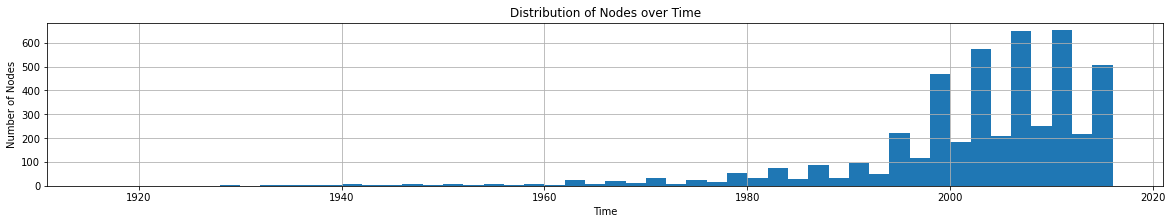

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000421,Along the Roadside,0.000241,Along the Roadside,0.000102,Along the Roadside,0.0,Along the Roadside
1,0.000060,Matthew Emerick,0.000000,Matthew Emerick,0.000022,Matthew Emerick,NaN,Matthew Emerick
2,0.000060,Brock Baker,0.000000,Brock Baker,0.000022,Brock Baker,NaN,Brock Baker
3,0.000060,Sheldon Bailey,0.000000,Sheldon Bailey,0.000022,Sheldon Bailey,NaN,Sheldon Bailey
4,0.000060,Zoran Lisinac,0.000000,Zoran Lisinac,0.000022,Zoran Lisinac,NaN,Zoran Lisinac


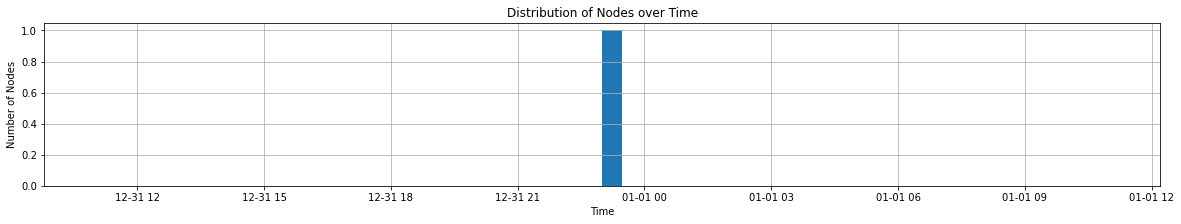

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000301,Short Cut to Nirvana: Kumbh Mela,0.000241,Short Cut to Nirvana: Kumbh Mela,0.000118,Short Cut to Nirvana: Kumbh Mela,0.0,Short Cut to Nirvana: Kumbh Mela
1,0.000060,The Dalai Lama,0.000000,The Dalai Lama,0.000029,The Dalai Lama,NaN,The Dalai Lama
2,0.000060,Jasper Johal,0.000000,Jasper Johal,0.000029,Jasper Johal,NaN,Jasper Johal
3,0.000060,Swami Krishnanad,0.000000,Swami Krishnanad,0.000029,Swami Krishnanad,NaN,Swami Krishnanad
4,0.000060,Maurizio Benazzo,0.000000,Maurizio Benazzo,0.000029,Maurizio Benazzo,NaN,Maurizio Benazzo


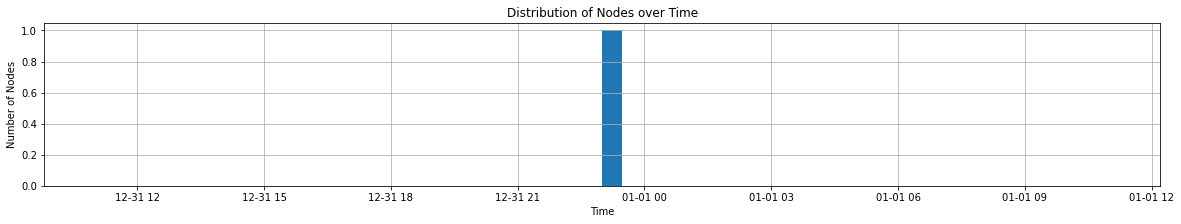

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000361,The Knife of Don Juan,0.000313,The Knife of Don Juan,0.000102,The Knife of Don Juan,0.0,The Knife of Don Juan
1,0.000060,Nataniel Sánchez,0.000000,Nataniel Sánchez,0.000024,Nataniel Sánchez,NaN,Nataniel Sánchez
2,0.000060,Antonio Arrué,0.000000,Antonio Arrué,0.000024,Antonio Arrué,NaN,Antonio Arrué
3,0.000060,Juan Carlos Montoya,0.000000,Juan Carlos Montoya,0.000024,Juan Carlos Montoya,NaN,Juan Carlos Montoya
4,0.000060,Tom Sanchez,0.000000,Tom Sanchez,0.000024,Tom Sanchez,NaN,Tom Sanchez


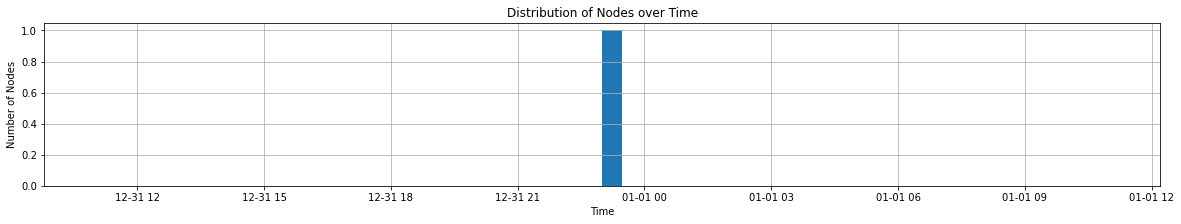

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000361,The Looking Glass,0.000263,The Looking Glass,0.000103,The Looking Glass,0.0,The Looking Glass
1,0.000060,Trish Basinger,0.000000,Trish Basinger,0.000024,Trish Basinger,NaN,Trish Basinger
2,0.000060,Elizabeth Stenholt,0.000000,Elizabeth Stenholt,0.000024,Elizabeth Stenholt,NaN,Elizabeth Stenholt
3,0.000060,Mary Norwood,0.000000,Mary Norwood,0.000024,Mary Norwood,NaN,Mary Norwood
4,0.000060,John D. Hancock,0.000000,John D. Hancock,0.000024,John D. Hancock,NaN,John D. Hancock


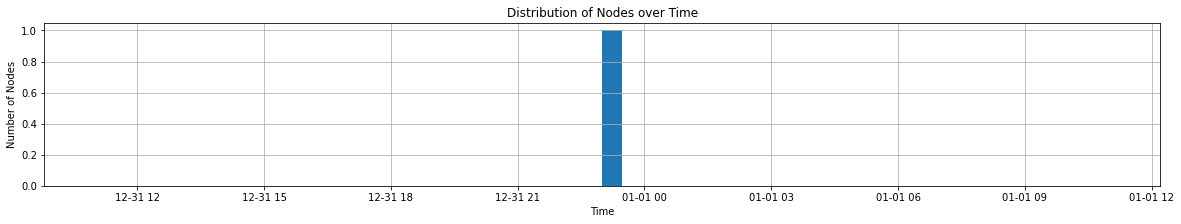

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')